In [198]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score
# from tensorflow.keras.models import Model
import keras.backend as K
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from tqdm import tqdm

In [199]:
# load in padded dataset
chonky_padded_waveforms = pd.read_parquet('padded_waveforms.parquet')

In [200]:
# us to timesteps
us2timesteps = 100

# convolution sizes
# bigger_steps = np.flip(np.arange(14*us2timesteps, 26*us2timesteps, 2*us2timesteps))
# print(bigger_steps)
# big_steps = np.flip(np.arange(1*us2timesteps, 13*us2timesteps, us2timesteps))
# med_steps = np.flip(np.arange(0.1*us2timesteps, 1*us2timesteps, 0.1*us2timesteps))
# smol_steps = np.flip(np.arange(0.01*us2timesteps, 0.1*us2timesteps, 0.01*us2timesteps))
# conv_sizes = np.concatenate((big_steps, med_steps, smol_steps))

# print(conv_sizes.shape)

In [201]:
# convolution sizes
bigger_steps = np.flip(np.arange(14*us2timesteps, 26*us2timesteps, 2*us2timesteps))
print(bigger_steps)
big_steps = np.flip(np.arange(1*us2timesteps, 13*us2timesteps, us2timesteps))
med_steps = np.flip(np.arange(0.1*us2timesteps, 1*us2timesteps, 0.1*us2timesteps))
smol_steps = np.flip(np.arange(0.01*us2timesteps, 0.1*us2timesteps, 0.01*us2timesteps))
conv_sizes = np.concatenate((bigger_steps, big_steps, med_steps, smol_steps))
# print(conv_sizes)

[2400 2200 2000 1800 1600 1400]


24.96419906616211
0.0
1.0
(7782, 3028)
(7782, 1)
3028


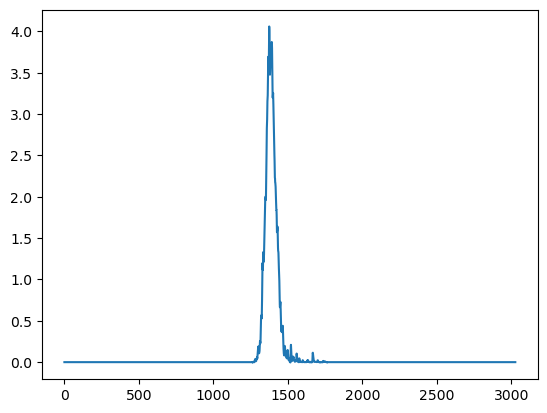

In [244]:
# finalising the data arrays
padded_array = chonky_padded_waveforms['chonkers'].to_numpy()
x_data = np.stack(padded_array, axis=0)

plt.figure()
plt.plot(x_data[100,:])

# divide by max phd
max_phd = x_data.max()
print(max_phd)
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)
y_data = chonky_padded_waveforms['label'].to_numpy().reshape((-1,1))
print(y_data.shape)
input_length = x_data.shape[-1]
print(input_length)

In [203]:
# get training and testing sets
runID = chonky_padded_waveforms['runID']
eventID = chonky_padded_waveforms['eventID']
W_array = chonky_padded_waveforms['weights_no_gas'].to_numpy()
# X_train, X_test, \
# y_train, y_test, \
# W_train, W_test, \
# runID_train, runID_test, \
# eventID_train, eventID_test = \
# train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)
# print(X_train.shape)
# print(y_train.shape)
# print(X_train)
# print(y_train)
# X_train_reshaped = np.expand_dims(X_train, axis=-1)
# print(X_train_reshaped.shape)

# print(W_train.shape)

In [204]:
# metrics
# def precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     return true_positives / (predicted_positives + K.epsilon())

# def recall(y_true, y_pred): 
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + K.epsilon())

# def f_beta(y_true, y_pred, beta=2):
#     precision_value = precision(y_true, y_pred)
#     recall_value = recall(y_true, y_pred)
#     numer = (1 + beta ** 2) * (precision_value * recall_value)
#     denom = ((beta ** 2) * precision_value) + recall_value + K.epsilon()
#     return numer / denom

# function to make a cnn
def one_layer_cnn_test(X_train, y_train, W_train, X_test, y_test, W_test, filter_size, num_filters=10, train_iters=30):
    CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu', input_shape=(input_length, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.005),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3)
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.1, shuffle=True, sample_weight=W_train, verbose=0, callbacks=[callback])
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    y_predicted = CNN_model.predict(X_test)
    y_predicted_label = [np.argmax(i) for i in y_predicted]
    f1score = fbeta_score(y_test, y_predicted_label, beta=1, labels=[2], average=None)
    f2score = fbeta_score(y_test, y_predicted_label, beta=2, labels=[2], average=None)
    f3score = fbeta_score(y_test, y_predicted_label, beta=3, labels=[2], average=None)
    return test_loss, test_acc, test_weight_acc, f1score, f2score, f3score

# Main cross-val loop

In [205]:
filter_number = 10
num_folds = 5

conv_sizes_layer1 = np.around(np.logspace(-2, 1.3, 30) * us2timesteps)
print(conv_sizes_layer1)
conv_sizes_layer1 = np.delete(conv_sizes_layer1, [1, 3])
print()
print(conv_sizes_layer1)

loss_arr = np.zeros((num_folds, len(conv_sizes_layer1)))
acc_arr = np.zeros((num_folds, len(conv_sizes_layer1)))
w_acc_arr = np.zeros((num_folds, len(conv_sizes_layer1)))
f1_arr = np.zeros((num_folds, len(conv_sizes_layer1)))
f2_arr = np.zeros((num_folds, len(conv_sizes_layer1)))
f3_arr = np.zeros((num_folds, len(conv_sizes_layer1)))

kfolds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

print('Number of Filters - ' + str(filter_number))
for j in tqdm(range(len(conv_sizes_layer1))):
    print('Filter Size - ' + str(conv_sizes_layer1[j]))
    fold_no = 1

    for train, test in kfolds.split(x_data, y_data):
        # print(type(x_data[train]))
        loss, acc, w_acc, f1, f2, f3 = one_layer_cnn_test(x_data[train], y_data[train], W_array[train], 
                                                          x_data[test], y_data[test], W_array[test], 
                                                          filter_size=int(conv_sizes_layer1[j]), num_filters=int(filter_number))

        loss_arr[fold_no-1, j] = loss
        acc_arr[fold_no-1, j] = acc
        w_acc_arr[fold_no-1, j] = w_acc
        f1_arr[fold_no-1, j] = f1
        f2_arr[fold_no-1, j] = f2
        f3_arr[fold_no-1, j] = f3

        # Increase fold number
        fold_no = fold_no + 1

[1.000e+00 1.000e+00 2.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00
 6.000e+00 8.000e+00 1.100e+01 1.400e+01 1.800e+01 2.300e+01 3.000e+01
 3.900e+01 5.100e+01 6.600e+01 8.600e+01 1.120e+02 1.450e+02 1.890e+02
 2.450e+02 3.190e+02 4.140e+02 5.380e+02 7.000e+02 9.090e+02 1.181e+03
 1.535e+03 1.995e+03]

[1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 8.000e+00
 1.100e+01 1.400e+01 1.800e+01 2.300e+01 3.000e+01 3.900e+01 5.100e+01
 6.600e+01 8.600e+01 1.120e+02 1.450e+02 1.890e+02 2.450e+02 3.190e+02
 4.140e+02 5.380e+02 7.000e+02 9.090e+02 1.181e+03 1.535e+03 1.995e+03]
Number of Filters - 10


  0%|          | 0/28 [00:00<?, ?it/s]

Filter Size - 1.0
49/49 [==============================] - 0s 2ms/step


  4%|▎         | 1/28 [00:59<26:55, 59.83s/it]

Filter Size - 2.0
49/49 [==============================] - 0s 2ms/step


  7%|▋         | 2/28 [01:47<22:52, 52.80s/it]

Filter Size - 3.0
49/49 [==============================] - 0s 2ms/step


 11%|█         | 3/28 [02:40<21:57, 52.69s/it]

Filter Size - 4.0
49/49 [==============================] - 0s 2ms/step


 14%|█▍        | 4/28 [03:26<20:05, 50.22s/it]

Filter Size - 5.0
49/49 [==============================] - 0s 2ms/step


 18%|█▊        | 5/28 [04:23<20:06, 52.45s/it]

Filter Size - 6.0
49/49 [==============================] - 0s 2ms/step


 21%|██▏       | 6/28 [05:12<18:52, 51.47s/it]

Filter Size - 8.0
49/49 [==============================] - 0s 3ms/step


 25%|██▌       | 7/28 [06:19<19:43, 56.36s/it]

Filter Size - 11.0
49/49 [==============================] - 0s 2ms/step


 29%|██▊       | 8/28 [07:16<18:52, 56.62s/it]

Filter Size - 14.0
49/49 [==============================] - 0s 3ms/step


 32%|███▏      | 9/28 [08:16<18:18, 57.82s/it]

Filter Size - 18.0
49/49 [==============================] - 0s 4ms/step


 36%|███▌      | 10/28 [09:10<16:57, 56.55s/it]

Filter Size - 23.0
49/49 [==============================] - 0s 3ms/step


 39%|███▉      | 11/28 [10:16<16:52, 59.54s/it]

Filter Size - 30.0
49/49 [==============================] - 0s 4ms/step


 43%|████▎     | 12/28 [11:10<15:23, 57.74s/it]

Filter Size - 39.0
49/49 [==============================] - 0s 3ms/step


 46%|████▋     | 13/28 [12:14<14:54, 59.67s/it]

Filter Size - 51.0
49/49 [==============================] - 0s 3ms/step


 50%|█████     | 14/28 [13:23<14:33, 62.38s/it]

Filter Size - 66.0
49/49 [==============================] - 0s 4ms/step


 54%|█████▎    | 15/28 [14:33<14:01, 64.71s/it]

Filter Size - 86.0
49/49 [==============================] - 0s 5ms/step


 57%|█████▋    | 16/28 [16:49<17:13, 86.10s/it]

Filter Size - 112.0
49/49 [==============================] - 0s 5ms/step


 61%|██████    | 17/28 [18:24<16:19, 89.05s/it]

Filter Size - 145.0
49/49 [==============================] - 0s 5ms/step


 64%|██████▍   | 18/28 [20:03<15:20, 92.04s/it]

Filter Size - 189.0
49/49 [==============================] - 0s 5ms/step


 68%|██████▊   | 19/28 [22:00<14:55, 99.51s/it]

Filter Size - 245.0
49/49 [==============================] - 0s 5ms/step


 71%|███████▏  | 20/28 [24:07<14:22, 107.76s/it]

Filter Size - 319.0
49/49 [==============================] - 0s 6ms/step


 75%|███████▌  | 21/28 [26:22<13:30, 115.77s/it]

Filter Size - 414.0
49/49 [==============================] - 0s 7ms/step


 79%|███████▊  | 22/28 [28:46<12:25, 124.19s/it]

Filter Size - 538.0
49/49 [==============================] - 0s 8ms/step


 82%|████████▏ | 23/28 [32:01<12:07, 145.45s/it]

Filter Size - 700.0
49/49 [==============================] - 1s 9ms/step


 86%|████████▌ | 24/28 [35:39<11:09, 167.32s/it]

Filter Size - 909.0
49/49 [==============================] - 0s 7ms/step


 89%|████████▉ | 25/28 [39:46<09:33, 191.16s/it]

Filter Size - 1181.0
49/49 [==============================] - 1s 8ms/step


 93%|█████████▎| 26/28 [43:55<06:57, 208.56s/it]

Filter Size - 1535.0
49/49 [==============================] - 1s 8ms/step


 96%|█████████▋| 27/28 [48:04<03:40, 220.81s/it]

Filter Size - 1995.0
49/49 [==============================] - 1s 10ms/step


100%|██████████| 28/28 [52:33<00:00, 112.64s/it]


In [206]:
# save metric arrays

np.save('loss_10filters', loss_arr)
np.save('acc_10filters', acc_arr)
np.save('w_acc_10filters', w_acc_arr)
np.save('f1_10filters', f1_arr)
np.save('f2_10filters', f2_arr)
np.save('f3_10filters', f3_arr)

[0.64893129 0.74552627 0.70419074 0.75135953 0.66656519 0.63674015
 0.67288516 0.66564409 0.69114408 0.72867146 0.74206915 0.71965231
 0.67634548 0.69481536 0.68782632 0.69693987 0.72566857 0.70515046
 0.72324633 0.68052105 0.62724258 0.66170039 0.78399169 0.73552968
 0.76300599 0.72008497 0.72799996 0.68091934]


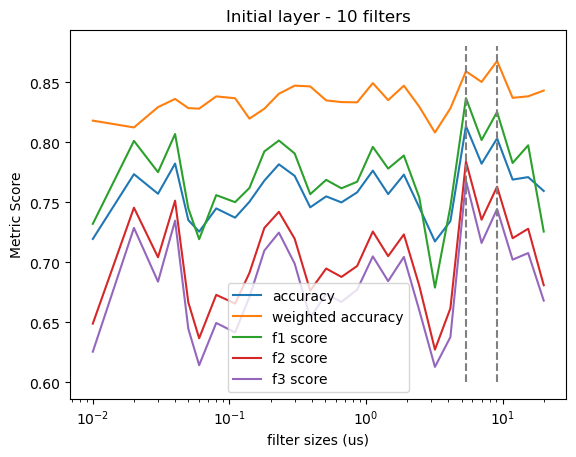

In [232]:
print(np.mean(f2_arr, axis=0))
# plt.figure()
# plt.loglog(conv_sizes_layer1 / us2timesteps, np.mean(f3_arr, axis=0))#, yerr=np.std(f2_arr, axis=0))
plt.figure()
plt.semilogx(conv_sizes_layer1 / us2timesteps, np.mean(acc_arr, axis=0), label='accuracy')
plt.semilogx(conv_sizes_layer1 / us2timesteps, np.mean(w_acc_arr, axis=0), label='weighted accuracy')
plt.semilogx(conv_sizes_layer1 / us2timesteps, np.mean(f1_arr, axis=0), label='f1 score')
plt.semilogx(conv_sizes_layer1 / us2timesteps, np.mean(f2_arr, axis=0), label='f2 score')
plt.semilogx(conv_sizes_layer1 / us2timesteps, np.mean(f3_arr, axis=0), label='f3 score')
plt.plot(np.zeros(50)+5.38, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
plt.plot(np.zeros(50)+9.09, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
# plt.plot(np.logspace(-2, 1.3), np.zeros(50)+0.78, linestyle='dashed', color='grey')
plt.xlabel('filter sizes (us)')
plt.ylabel('Metric Score')
plt.title('Initial layer - 10 filters')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

# Cross-val for 5.38us filter size and varying num filters

In [235]:
filter_number = np.linspace(2, 20, 10)
num_folds = 5

print(filter_number)

# conv_sizes_layer1 = np.around(np.logspace(-2, 1.3, 30) * us2timesteps)
# print(conv_sizes_layer1)
# conv_sizes_layer1 = np.delete(conv_sizes_layer1, [1, 3])
# print()
# print(conv_sizes_layer1)

conv_sizes_fixed = 538

loss_arr = np.zeros((num_folds, len(filter_number)))
acc_arr = np.zeros((num_folds, len(filter_number)))
w_acc_arr = np.zeros((num_folds, len(filter_number)))
f1_arr = np.zeros((num_folds, len(filter_number)))
f2_arr = np.zeros((num_folds, len(filter_number)))
f3_arr = np.zeros((num_folds, len(filter_number)))

kfolds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)

print('Filter Size - ' + str(conv_sizes_fixed))
for j in tqdm(range(len(filter_number))):
    print('Number of Filters - ' + str(filter_number[j]))
    fold_no = 1

    for train, test in kfolds.split(x_data, y_data):
        # print(type(x_data[train]))
        loss, acc, w_acc, f1, f2, f3 = one_layer_cnn_test(x_data[train], y_data[train], W_array[train], 
                                                          x_data[test], y_data[test], W_array[test], 
                                                          filter_size=int(conv_sizes_fixed), num_filters=int(filter_number[j]))

        loss_arr[fold_no-1, j] = loss
        acc_arr[fold_no-1, j] = acc
        w_acc_arr[fold_no-1, j] = w_acc
        f1_arr[fold_no-1, j] = f1
        f2_arr[fold_no-1, j] = f2
        f3_arr[fold_no-1, j] = f3

        # Increase fold number
        fold_no = fold_no + 1

[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
Filter Size - 538


  0%|          | 0/10 [00:00<?, ?it/s]

Number of Filters - 2.0
49/49 [==============================] - 0s 6ms/step


 10%|█         | 1/10 [02:14<20:12, 134.70s/it]

Number of Filters - 4.0
49/49 [==============================] - 0s 8ms/step


 20%|██        | 2/10 [04:30<18:03, 135.46s/it]

Number of Filters - 6.0
49/49 [==============================] - 1s 11ms/step


 30%|███       | 3/10 [06:34<15:12, 130.30s/it]

Number of Filters - 8.0
49/49 [==============================] - 1s 7ms/step


 40%|████      | 4/10 [09:08<13:56, 139.34s/it]

Number of Filters - 10.0
49/49 [==============================] - 1s 12ms/step


 50%|█████     | 5/10 [11:55<12:26, 149.33s/it]

Number of Filters - 12.0
49/49 [==============================] - 1s 12ms/step


 60%|██████    | 6/10 [15:29<11:25, 171.35s/it]

Number of Filters - 14.0
49/49 [==============================] - 1s 14ms/step


 70%|███████   | 7/10 [18:44<08:57, 179.25s/it]

Number of Filters - 16.0
49/49 [==============================] - 1s 18ms/step


 80%|████████  | 8/10 [21:17<05:41, 170.74s/it]

Number of Filters - 18.0
49/49 [==============================] - 1s 23ms/step


 90%|█████████ | 9/10 [25:33<03:17, 197.38s/it]

Number of Filters - 20.0
49/49 [==============================] - 1s 16ms/step


100%|██████████| 10/10 [30:29<00:00, 182.93s/it]


In [1]:
print(np.mean(f2_arr, axis=0))
# plt.figure()
# plt.loglog(conv_sizes_layer1 / us2timesteps, np.mean(f3_arr, axis=0))#, yerr=np.std(f2_arr, axis=0))
plt.figure()
plt.plot(filter_number, np.mean(acc_arr, axis=0), label='accuracy')
plt.plot(filter_number, np.mean(w_acc_arr, axis=0), label='weighted accuracy')
plt.plot(filter_number, np.mean(f1_arr, axis=0), label='f1 score')
plt.plot(filter_number, np.mean(f2_arr, axis=0), label='f2 score')
plt.plot(filter_number, np.mean(f3_arr, axis=0), label='f3 score')
plt.plot(np.zeros(50)+6, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
plt.plot(np.zeros(50)+14, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
# plt.plot(np.zeros(50)+9.09, np.linspace(0.6,0.88), linestyle='dashed', color='grey')
# plt.plot(np.logspace(-2, 1.3), np.zeros(50)+0.78, linestyle='dashed', color='grey')
plt.xlabel('Number of Filters')
plt.ylabel('Metric Score')
plt.title('Initial layer - 5.38us Filter Size')
# plt.xscale='log'
# plt.yscale='log'
# plt.legend()

NameError: name 'np' is not defined